# Библиотеки

In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
# для подбора гипер параметров в моделях
from sklearn.metrics import mean_absolute_error, mean_squared_error
# метрики с функциями потерь

%matplotlib inline 
# отображает графику в юпитере
%config IPCompleter.greedy=True 
# должно ускорять работу таба

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# энкодеры для преобразования качественных признаков в количественные
from sklearn.compose import ColumnTransformer
# строит столбцы для ванхот энкодера

In [ ]:
from catboost import CatBoostClassifier, Pool, sum_models
# библиотека бустинга от яндекса

# Код для предобработки файлов, удобного чтения в юпитере

In [87]:
f = open('IoTScenarios/CTU-IoT-Malware-Capture-49-1/bro/conn.log.labeled', 'r')
g = open('IoT/CTU-IoT-Malware-Capture-49-1/conn.log.labeled', 'w')
zlo = '   '
pra = '	'
sc = 0
for line in f:
    if sc < 7:                # для удаления шапки файла
        line = ''
        sc += 1
        continue
    if line[0:6] == '#close': # для удаления подвала файла
        line = ''
        sc += 1
        continue
    if sc == 7:
        line = line.replace('   ', '	')
        g.write(line[7:])
        sc += 1
        continue
    if sc > 7:
        line = line.replace('   ', '	')
        g.write(line)
f.close()
g.close()

# Предобработка (разбивка) больших файлов

In [ ]:
# файлы создаются по 5 000 000 замеров

In [ ]:
# код для создания первой части (файла) большого файла
f = open('IoT/CTU-IoT-Malware-Capture-17-1/conn.log.labeled', 'r')
g = open('IoT/CTU-IoT-Malware-Capture-17-1/17_1.log.labeled', 'w')
zlo = '   '
pra = '	'
sc = 0
for line in f:
    if sc < 5000001:
        line = line.replace('   ', '	')
        g.write(line)
        sc += 1
        continue
    if 5000001 == sc:
        break
f.close()
g.close()

In [ ]:
scc = 2
# счетчик номера файла
al = 10000001
# счеткик измерений

In [ ]:
# код для создания последующих частей (файлов) большого файла
# при запуске данного кода в цикле будет зацикливание на запись последнего файла
fail = 'IoT/CTU-IoT-Malware-Capture-17-1/17_'+ str(scc) + '.log.labeled'
f = open('IoT/CTU-IoT-Malware-Capture-17-1/conn.log.labeled', 'r')
g = open(fail, 'w')
sc = 0
for line in f:
    if sc == 0:
        g.write(line)
        sc += 1
        continue
    if  sc <= al - 5000000:
        line = ''
        sc += 1
        continue
    if al >= sc > al - 5000000:
        g.write(line)
        sc += 1
        continue
    if sc > al:
        scc += 1
        al += 5000000
        break
f.close()
g.close()

# Загрузка данных 

In [13]:
df = dd.read_csv('IoT/CTU-IoT-Malware-Capture-1-1/conn.log.labeled', sep = '	')
# используется для больших файлов не влезающих в память

In [ ]:
# НЕ ЗАПУСКАТЬ! Не работает
data = df.loc[:1].compute()
data = data.compute()
# получаем дата фрейм пандаса небольшого размера от исходного

In [88]:
df = pd.read_csv('IoT/CTU-IoT-Malware-Capture-49-1/conn.log.labeled', sep = '	')
# для маленьких файлов

C:\Users\ALEX\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Обработка времени

In [ ]:
df['time'] = pd.to_datetime(df['time'],unit='s')
#преобразование линвремя в норм дату и к типу дыты
date = df['time'].apply(lambda x: x.date()).sort_values()
# массив из дат по выборке либо времени(x.time)
date
#тут видны границы времени

In [ ]:
day = big['time'].apply(lambda x: x.timetuple().tm_yday)
# получаем день в году
hour = big['time'].apply(lambda x: x.hour)
# получаем час

day = pd.DataFrame(day)
hour = pd.DataFrame(hour)
# преобразуем в датафреймы
day.rename(columns={'time': 'day'}, inplace=True)
hour.rename(columns={'time': 'hour'}, inplace=True)
# меняем название столбцов
# код не обязательный, но оставлю

big.insert(1, 'hour', hour)
big.insert(1, 'day', day)
# добавляем новые признаки в начало датафрейма

In [ ]:
big = big.drop('time', axis = 1)
# удаляем старый признак

# Анализ структуры данных

In [80]:
df.head()
# вывод шапки датасета

,time,string,addr,port,addr.1,port.1,enum,string.1,interval,count,...,bool.1,count.2,string.3,count.3,count.4,count.5,count.6,set[string],string.4,string.5
0,2019-09-20 00:40:58.775321960,CEjjLs1iwWYrt8C4O6,192.168.1.195,123,212.111.30.190,123,udp,-,0.008239,96,...,-,0,Dd,2,152,2,152,-,Benign,-
1,2019-09-20 00:41:59.775273085,CHNzmm3tMu5Gse9Zvg,192.168.1.195,123,89.221.218.101,123,udp,-,0.007496,96,...,-,0,Dd,2,152,2,152,-,Benign,-
2,2019-09-20 00:43:51.016249895,CDlbowGNUwsHckADd,192.168.1.195,37120,102.165.48.81,17769,tcp,-,1.848549,518,...,-,0,ShAdfDr,10,1572,8,540,-,Malicious,C&C-HeartBeat
3,2019-09-20 00:40:41.665907145,CxKxhj4MGsf5GcqoX6,192.168.1.1,47805,192.168.1.195,22,tcp,-,206.663644,2768,...,-,0,DdAaFf,400,26336,268,36368,-,Benign,-
4,2019-09-20 00:44:11.392718077,C2n3PK3bA92hAgTHda,192.168.1.195,37122,102.165.48.81,17769,tcp,-,1.902519,518,...,-,0,ShAdfDr,10,1572,8,540,-,Malicious,C&C-HeartBeat


In [89]:
df.shape
# вывод размерности датасета

(5410561, 23)

In [81]:
df['string.5'].value_counts()
# вывод какие целевые признаки присутствуют

DDoS             3578457
-                   2476
C&C-HeartBeat         95
Name: string.5, dtype: int64

In [85]:
df['addr'].value_counts()

192.168.1.195      3579013
162.248.88.215        2013
192.168.1.1              1
184.103.250.171          1
Name: addr, dtype: int64

In [43]:
x.isnull().sum()
# проверка на наличие пропущенных значений

time           0
string         0
addr           0
port           0
addr.1         0
port.1         0
enum           0
string.1       0
interval       0
count          0
count.1        0
string.2       0
bool           0
bool.1         0
count.2        0
string.3       0
count.3        0
count.4        0
count.5        0
count.6        0
set[string]    0
string.4       0
dtype: int64

In [8]:
df.info()
# я тут смотрю типы всех признаков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008748 entries, 0 to 1008747
Data columns (total 23 columns):
time           1008748 non-null float64
string         1008748 non-null object
addr           1008748 non-null object
port           1008748 non-null int64
addr.1         1008748 non-null object
port.1         1008748 non-null int64
enum           1008748 non-null object
string.1       1008748 non-null object
interval       1008748 non-null object
count          1008748 non-null object
count.1        1008748 non-null object
string.2       1008748 non-null object
bool           1008748 non-null object
bool.1         1008748 non-null object
count.2        1008748 non-null int64
string.3       1008748 non-null object
count.3        1008748 non-null int64
count.4        1008748 non-null int64
count.5        1008748 non-null int64
count.6        1008748 non-null int64
set[string]    1008748 non-null object
string.4       1008748 non-null object
string.5       1008748 non-null obj

In [20]:
df.describe()
# полезная мат стата для числовых признаков

,port,port.1,count.2,count.3,count.4,count.5,count.6
count,1.044779e+07,1.044779e+07,1.044779e+07,1.044779e+07,1.044779e+07,1.044779e+07,1.044779e+07
mean,4.392035e+04,1.226664e+02,1.827036e+02,4.480689e+00,1.925015e+02,1.177666e-03,5.034089e-01
std,1.268259e+04,2.903562e+02,5.905446e+05,2.624295e+03,7.348052e+04,1.454875e+00,3.971355e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.742200e+04,2.300000e+01,0.000000e+00,1.000000e+00,6.000000e+01,0.000000e+00,0.000000e+00
50%,4.544000e+04,2.300000e+01,0.000000e+00,3.000000e+00,1.200000e+02,0.000000e+00,0.000000e+00
75%,5.345000e+04,2.300000e+01,0.000000e+00,3.000000e+00,1.800000e+02,0.000000e+00,0.000000e+00
max,6.553500e+04,5.998400e+04,1.908819e+09,4.216883e+06,1.180727e+08,4.621000e+03,4.134880e+05


In [62]:
df.corr()
# корреляция числовых признаков

,port,port.1,count.2,count.3,count.4,count.5,count.6
port,1.000000,-0.151648,-0.018477,-0.038584,-0.005219,-0.035173,-0.027266
port.1,-0.151648,1.000000,-0.008687,0.106227,0.005154,0.046171,0.004563
count.2,-0.018477,-0.008687,1.000000,0.008825,0.000049,0.198674,0.873288
count.3,-0.038584,0.106227,0.008825,1.000000,0.686961,0.027778,0.015651
count.4,-0.005219,0.005154,0.000049,0.686961,1.000000,0.000235,0.000091
count.5,-0.035173,0.046171,0.198674,0.027778,0.000235,1.000000,0.437721
count.6,-0.027266,0.004563,0.873288,0.015651,0.000091,0.437721,1.000000


# Описание преобразования признаков

In [ ]:
# 1. bool и bool.1 выкинул т.к. в данной выборке они одинаковы у всех обьектов и равны "-"
# 2. Из time взял два признака day - показывает день в году, когда было данное событие
# и признак hour - показывает в каком часу было  событие, сам признак time удалил
# 3. признаки enum, string.1, set[string] были преобразованы в новые признаки методом ван хот
# enum(icmp), enum(tcp), enum(upd) и string.1(irc), string.1(ssh), string.1(ssl), string.1(dhcp),
# string.1(http), string.1(dns), string.1(-) и set[string](-), set[string]((empty)) соответственно
# 4. значения равные '-' в признаках interval, count, count.1 были заменены на -1, после
# чего данные признаки были приведены к числовому типу
# 5. признак string имеет число значений равное числу событий и визуально похож на хэш,
# из за этого он не несет полезных данных для модели и был удален
# 6. признаки string.2, string.3 и addr, addr.1 были приведены к числовым лабел кодером
#

In [ ]:
big = big.drop('Unnamed:', axis = 1)
# выкидывает признак из датафрейма

In [ ]:
ohe = ColumnTransformer([("One hot", OneHotEncoder(sparse=False),[6])])
# создаем модель энкодера
# P.S. из-за ошибки в библиотеке номер столбца задается здесь, а не именем/номером при обучении

In [ ]:
x_1 = pd.DataFrame(ohe.fit_transform(big))
# создаем датафрейм с новыми признаками полученными из одного старого
# P.S. Можно инсертом его сразу запихать в основной датафрейм, но я переименовывал столбцы в нем
# и запихивал по одному для большей интепретации модели, более простой способ не нашел пока

In [16]:
x_1.head()
# пример такого фрейма

,0,1,2,3
0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0


In [ ]:
big.loc[big['interval'] == '-', 'interval'] = '-1'
# меняем все значения "-" в признаке на число
big['interval']=big['interval'].astype(float)
# преобразуем качественный признак в числовой

In [ ]:
labelencoder = LabelEncoder()
# создаем модель энкодера
big["addr.1"] = labelencoder.fit_transform(big["addr.1"])
# заменяем значение признака на числа 1,2,3 и тд.

# Визуализация данных

In [72]:
plt.rcParams['figure.figsize'] = [12, 6]
# определяет размер графиков по умолчанию

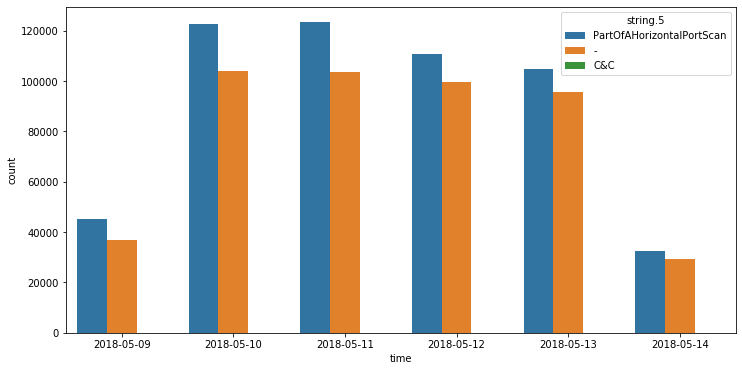

In [73]:
sns.countplot(x = date, hue = 'string.5', data = df);
# визуализация целевого признака по дням

In [55]:
# в big датасет были сложены данные без ярких выбросов
# (1,3,8,20,21,34,42,44 и 4,5,7 с нормальным трафиком)
date = big['time'].dt.date
# получаем массив дней без времени
hour = big['time'].apply(lambda x: x.hour)
# получаем массив часов без даты и минут

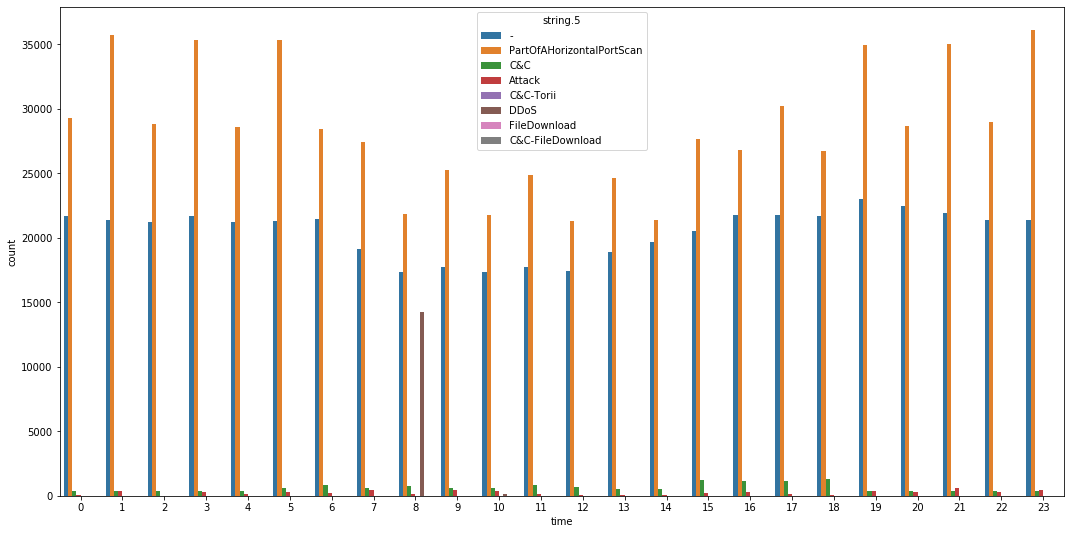

In [60]:
hour = big['time'].apply(lambda x: x.hour)sns.countplot(x = hour, hue = 'string.5', data = big);
# трафик в зависимости от часа дня для big

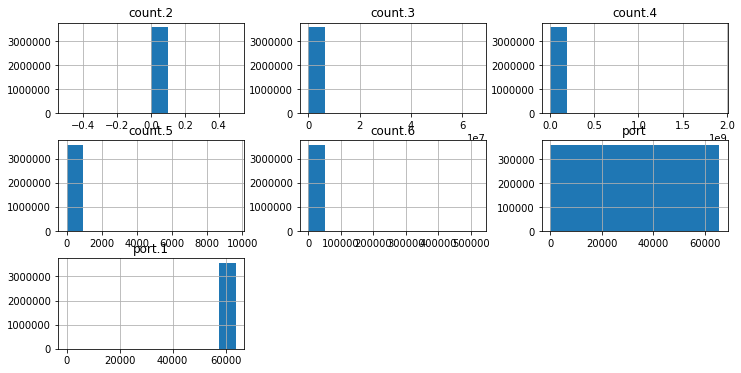

In [82]:
df.hist();
# графики для быстрого анализа